In [1]:
from multiprocessing import Pool
import numpy as np
from graph import Circle, Grid, RandomRegular, GraphByDegrees, ErdosRenyi, ScaleFree, SmallWorld
from viz import draw_data
from utils import Timer, partition
from engine import fun
from engine_mono import fun_mono
from engine_sum import fun_sum
from engine_tot import fun_tot
from graph_toolset import coreness, degs
import jupyternotify
import random
import matplotlib.cm as cm
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

# from scipy.misc import imresize
"""
import matplotlib as mpl
import matplotlib.font_manager as font_manager

mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
"""
import matplotlib.pyplot as plt


from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

import pickle

%matplotlib notebook

<IPython.core.display.Javascript object>

In [2]:
def total(graph, keys):
    res = dict()
    if 'rho' in keys:
        res['rho'] = graph.V
    if 'l' in keys:
        res['l'] = graph.V
    return res

In [3]:
def addr(filename):
    return '/home/zhuk1996/data/' + filename + '.pkl'

In [4]:
def calc(fun_name, alphas, bs, graphs, T, out_file, init_type='01', keys=['rho', 'l'], set_builder=total, pool_size=32):
    pool = Pool(pool_size)
    
    res = dict()
    for key in keys:
        res[key] = []

    timer = Timer()
    
    now = 0
    
    for graph in graphs:
        local_timer = Timer()
        
        sets = set_builder(graph, keys)
        
        points = [(graph, b, alpha, T, init_type, sets) for alpha in alphas for b in bs]
        
        if fun_name == 'fun':
            cur = pool.map(fun, points)
        elif fun_name == 'mono':
            cur = pool.map(fun_mono, points)
        elif fun_name == 'sum':
            cur = pool.map(fun_sum, points)
        elif fun_name == 'tot':
            cur = pool.map(fun_tot, points)
        else:
            raise Exception(f'dont know fun name {fun_name}!')
        
        for key in keys:
            tmp = []
            for step in cur:
                tmp.append(step[key])
            
            tmp = np.array(tmp)
            tmp = np.reshape(tmp, (len(alphas), len(bs), tmp.shape[1]))
            res[key].append(tmp)
        
        t = local_timer.measure()
        now += 1
        rem = len(graphs) - now
        print(f'#{now} passed in {local_timer.measure()},  projected end in {timer.measure() / now * rem / 60} minutes', flush=True)
        
    for key in keys:
        res[key] = np.array(res[key])
        
    timer.print_elapsed()
    
    with open(addr(out_file), 'wb') as f:
        pickle.dump(res, f)
    
    print(f'Written to {addr(out_file)}')
    

In [5]:
def cut_alpha(data, alpha_id):
    res = dict()
    for key, arr in data.items():
        res[key] = arr[:, alpha_id, :, :]
    return res

In [6]:
def plot_means(bs, data, last, keys, title, show_data=False):
    fig, ax = plt.subplots()
    
    for key in keys:
        cur = np.apply_along_axis(np.mean, 2, data[key][:, :, -last:])
        if show_data:
            for t in cur:
                ax.scatter(bs, t, s=1, alpha=.5)

        cur = np.apply_along_axis(np.mean, 0, cur)
        # cur = np.apply_along_axis(np.median, 0, cur)
        ax.plot(bs, cur, '-', label=f'{key}')
    # ax.legend()
    ax.set_title(title)
    plt.show()

In [7]:
def single(bs, filename, last, keys, name, show_data=True):
    fig, ax = plt.subplots(figsize=(3 * 3, 2.5 * 2))
    plt.locator_params(axis='y', nbins=5)
    plt.locator_params(axis='x', nbins=10)
    
    with open(addr(filename), 'rb') as f:
        data = cut_alpha(pickle.load(f), 0)

        
        for key in keys:
            if key.startswith('std'):
                cur = np.apply_along_axis(np.std, 2, data[key[3:]][:, :, -last:])
            else:
                cur = np.apply_along_axis(np.mean, 2, data[key][:, :, -last:])
            if show_data:
                for t in cur:
                    ax.scatter(bs, t, s=1, alpha=.5, c='red')

            cur = np.apply_along_axis(np.mean, 0, cur)
            # cur = np.apply_along_axis(np.median, 0, cur)
            ax.plot(bs, cur, '-', label=f'{key}')
        ax.set_title(name)

    plt.show()

In [34]:
def plot_2d(bs, filenames, last, keys, names, show_data=True):
    fig, grid = plt.subplots(nrows=2, ncols=3, figsize=(3 * 3, 2.5 * 2), sharex=True, sharey=True)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.2)
    plt.locator_params(axis='y', nbins=5)
    plt.locator_params(axis='x', nbins=10)
    
    for name, filename, s in zip(names, filenames, range(len(names))):
        with open(addr(filename), 'rb') as f:
            data = cut_alpha(pickle.load(f), 0)
        
        i = s // 3
        j = s % 3
        
        ax = grid[i][j]
        
        for key in keys:
            if key.startswith('std'):
                cur = np.apply_along_axis(np.std, 2, data[key[3:]][:, :, -last:])
            else:
                cur = np.apply_along_axis(np.mean, 2, data[key][:, :, -last:])
            if show_data:
                for t in cur:
                    ax.scatter(bs, t, s=1, alpha=.5, c='red')

            cur = np.apply_along_axis(np.mean, 0, cur)
            # cur = np.apply_along_axis(np.median, 0, cur)
            ax.plot(bs, cur, '-', label=f'{key}')
        # ax.legend()
        if j == 0:
            ax.set_ylabel(r'$\rho$')
        if i == 1:
            ax.set_xlabel(r'$b$')
        ax.set_title(name)

    plt.show()

<IPython.core.display.Javascript object>


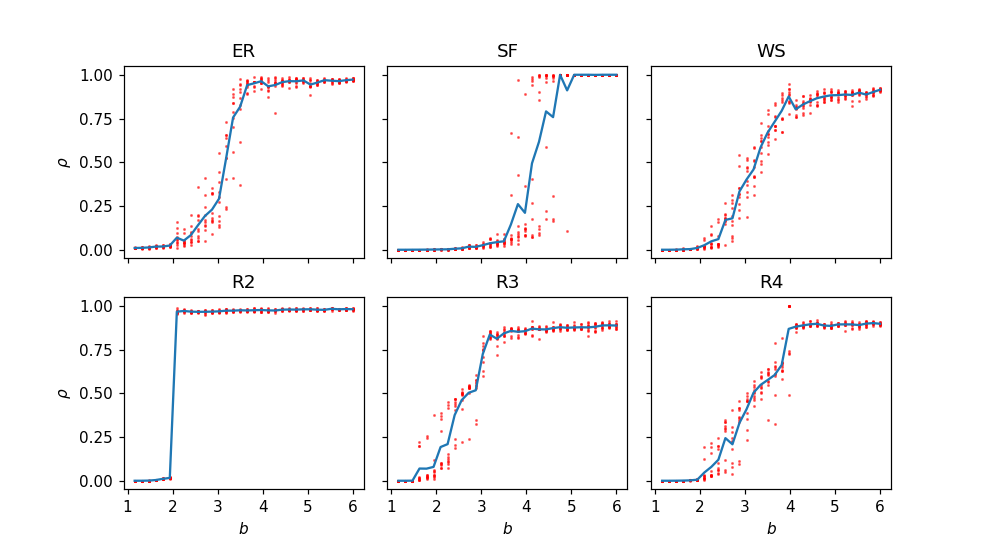

In [35]:
plot_of_prefix('bmono', 100)

<IPython.core.display.Javascript object>


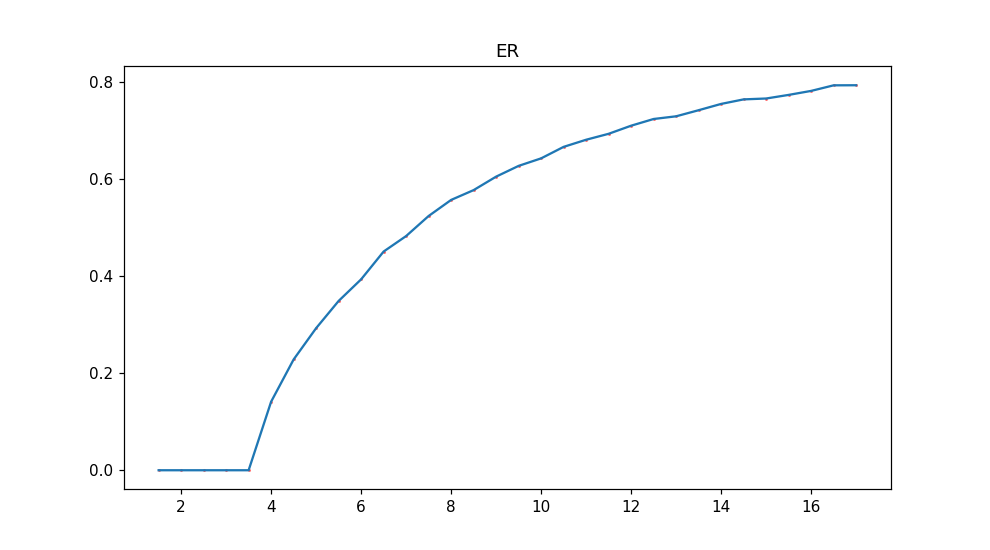

In [13]:
single(bs, 'btot_er', 1000, ['rho'], 'ER')

In [11]:
calc('tot', alphas, bs, er_graphs[:1], 10000, 'btot_er')

#1 passed in 293.1235988140106,  projected end in 0.0 minutes
time elapsed = 293.1308641433716
Written to /home/zhuk1996/data/btot_er.pkl


In [26]:
plot_2d(bs, names, 100, ['rho'], ['ER', 'SF', 'WS', 'R2', 'R3', 'R4'])

NameError: name 'names' is not defined

In [14]:
def run_and_draw(prefix, fun, cnt, steps, draw):
    timer = Timer()
    names = [prefix + suffix for suffix in ['_er', '_sf', '_ws', '_two', '_three', '_four']]
    for name, graphs in zip(names, 
                            [er_graphs, sf_graphs, ws_graphs, two_graphs, three_graphs, four_graphs]):
        calc(fun, alphas, bs, graphs[:cnt], steps, name)
    print(f'overall time = {timer.measure() / 60} mins')
    # plot_2d(bs, names, draw, ['rho'], ['ER', 'SF', 'WS', 'R2', 'R3', 'R4'])

In [20]:
def plot_of_prefix(prefix, draw):
    names = [prefix + suffix for suffix in ['_er', '_sf', '_ws', '_two', '_three', '_four']]
    plot_2d(bs, names, draw, ['rho'], ['ER', 'SF', 'WS', 'R2', 'R3', 'R4'])

In [ ]:
plot_of_prefix('bsum', 100)

In [ ]:
run_and_draw('bsum', 'sum', 10, 500, 10)

#1 passed in 33.61820864677429,  projected end in 5.042748534679413 minutes
#2 passed in 32.28765273094177,  projected end in 4.3941208998362224 minutes
#3 passed in 33.4943687915802,  projected end in 3.8659314023123845 minutes
#4 passed in 31.943612337112427,  projected end in 3.283902734518051 minutes
#5 passed in 32.43235158920288,  projected end in 2.7298253973325095 minutes
#6 passed in 32.8021285533905,  projected end in 2.1843637201521133 minutes
#7 passed in 32.966057777404785,  projected end in 1.6397132175309317 minutes
#8 passed in 35.52595663070679,  projected end in 1.1045303692420323 minutes
#9 passed in 33.28863859176636,  projected end in 0.5525509379528187 minutes
#10 passed in 33.540645599365234,  projected end in 0.0 minutes
time elapsed = 331.9301061630249
Written to /home/zhuk1996/data/bsum_er.pkl
#1 passed in 40.649632692337036,  projected end in 6.097460567951202 minutes
#2 passed in 42.44806456565857,  projected end in 5.540261554718017 minutes
#3 passed in 39.

#1 passed in 25.830744743347168,  projected end in 3.8746169328689577 minutes
#2 passed in 25.751843452453613,  projected end in 3.4390023867289226 minutes
#3 passed in 26.335837841033936,  projected end in 3.030294193161858 minutes
#4 passed in 26.095161199569702,  projected end in 2.6004511535167696 minutes
#5 passed in 27.102720499038696,  projected end in 2.1853642503420514 minutes
#6 passed in 26.926128149032593,  projected end in 1.7561002863778008 minutes
#7 passed in 26.13155746459961,  projected end in 1.3155827045440673 minutes
#8 passed in 26.46944308280945,  projected end in 0.8777168661355972 minutes
#9 passed in 26.203171014785767,  projected end in 0.4386227598896733 minutes
#10 passed in 26.140676021575928,  projected end in 0.0 minutes
time elapsed = 263.001748085022
Written to /home/zhuk1996/data/bmono_er.pkl
#1 passed in 32.06033158302307,  projected end in 4.8090553164482115 minutes
#2 passed in 31.853506565093994,  projected end in 4.261109097798665 minutes
#3 pass

<IPython.core.display.Javascript object>


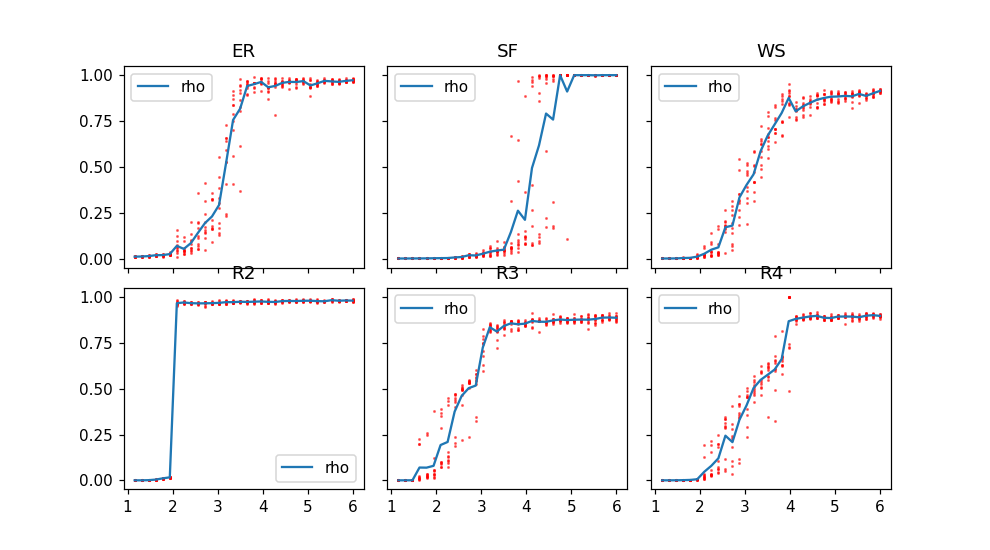

In [18]:
run_and_draw('bmono', 'mono', 10, 500, 100)

#1 passed in 28.382172107696533,  projected end in 4.257333540916443 minutes
#2 passed in 27.36422824859619,  projected end in 3.7165634791056315 minutes
#3 passed in 28.130391597747803,  projected end in 3.26201264195972 minutes
#4 passed in 27.3086519241333,  projected end in 2.7797432839870453 minutes
#5 passed in 27.63118624687195,  projected end in 2.313697099685669 minutes
#6 passed in 27.413211345672607,  projected end in 1.8470660209655763 minutes
#7 passed in 27.058793544769287,  projected end in 1.3806822419166564 minutes
#8 passed in 26.877317905426025,  projected end in 0.9173899541298548 minutes
#9 passed in 30.110276222229004,  projected end in 0.4634901002601341 minutes
#10 passed in 27.472754955291748,  projected end in 0.0 minutes
time elapsed = 277.76654958724976
Written to /home/zhuk1996/data/btot_er.pkl
#1 passed in 45.46035718917847,  projected end in 6.819062197208405 minutes
#2 passed in 45.71649408340454,  projected end in 6.078607575098673 minutes
#3 passed in 

<IPython.core.display.Javascript object>


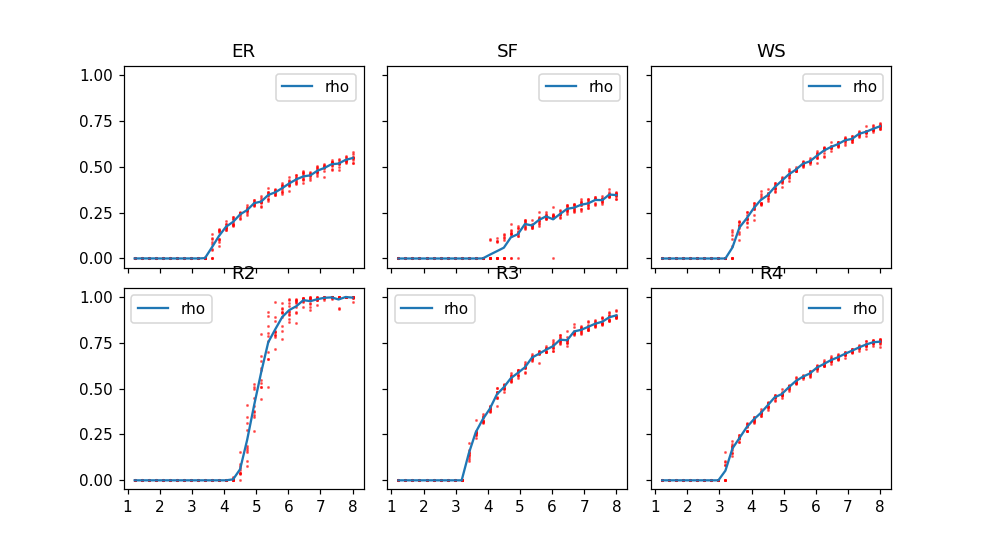

Process ForkPoolWorker-496:
Process ForkPoolWorker-538:
Process ForkPoolWorker-471:
Process ForkPoolWorker-576:
Process ForkPoolWorker-401:
Process ForkPoolWorker-568:
Process ForkPoolWorker-565:
Process ForkPoolWorker-454:
Process ForkPoolWorker-432:
Process ForkPoolWorker-489:
Process ForkPoolWorker-436:
Process ForkPoolWorker-399:
Process ForkPoolWorker-540:
Process ForkPoolWorker-508:
Process ForkPoolWorker-563:
Process ForkPoolWorker-541:
Process ForkPoolWorker-483:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.

  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._ta

  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/us

In [16]:
run_and_draw('btot', 'tot')

In [8]:
def print_info(filename):
    with open(addr(filename), 'rb') as f:
            data = pickle.load(f)
            print(data['rho'].shape)

In [9]:
print_info('sum_er')

(20, 32, 32, 600)


In [17]:
bs = partition(1, 6, 32)
alphas = [.1]
n = 1000
cnt = 10
print(bs)
print(alphas)

[1.15625 1.3125  1.46875 1.625   1.78125 1.9375  2.09375 2.25    2.40625
 2.5625  2.71875 2.875   3.03125 3.1875  3.34375 3.5     3.65625 3.8125
 3.96875 4.125   4.28125 4.4375  4.59375 4.75    4.90625 5.0625  5.21875
 5.375   5.53125 5.6875  5.84375 6.     ]
[0.1]


In [10]:
def ER(t):
    return ErdosRenyi(*t)

def SF(t):
    return ScaleFree(*t)

def WS(t):
    return SmallWorld(*t)

er_graphs = Pool(32).map(ER, [(n, 4. / n)] * cnt)
sf_graphs = Pool(32).map(SF, [(n, 4)] * cnt)
ws_graphs = Pool(32).map(WS, [(n, 4, .5)] * cnt)
four_graphs = Pool(32).map(GraphByDegrees, [{4: n}] * cnt)
two_graphs = Pool(32).map(GraphByDegrees, [{2: n}] * cnt)
three_graphs = Pool(32).map(GraphByDegrees, [{3: n}] * cnt)